In [1]:
import json, pandas as pd
# Load city graph and analysis
city_grid = json.load(open('city_grid.json'))
city_analysis = json.load(open('city_analysis.json'))
streetlights = json.load(open('streetlights.json'))
veh = pd.read_csv('vehicles_log_1.csv')
ped = pd.read_csv('pedestrians_log_1.csv')

print(f"Intersections: {city_analysis['total_intersections']}, Roads: {city_analysis['total_roads']}, Streetlights: {city_analysis['total_streetlights']}")
print(f"Vehicle entries: {len(veh)}, Pedestrian entries: {len(ped)}")
print(f"Nodes in city_grid: {len(city_grid['nodes'])}, Edges: {len(city_grid['links'])}")
print(f"No. of roads without streetlights: {len(city_analysis['roads_without_streetlights'])}")


Intersections: 225, Roads: 420, Streetlights: 1551
Vehicle entries: 99716, Pedestrian entries: 137801
Nodes in city_grid: 225, Edges: 420
No. of roads without streetlights: 0


In [2]:
from collections import defaultdict
veh_counts = defaultdict(int)
ped_counts = defaultdict(int)
for df, counts in [(veh, veh_counts), (ped, ped_counts)]:
    for _, row in df.iterrows():
        hour = int(row['hour'])
        nodes = row['path'].split("-")
        for i in range(len(nodes)-1):
            segment = f"{nodes[i]}-{nodes[i+1]}"
            counts[(segment, hour)] += 1

# Average per day (2 days in logs)
days = veh['day'].nunique()
traffic_data = {}
for road in city_analysis['road_stats'].keys():
    veh_hourly = []
    ped_hourly = []
    for h in range(24):
        veh_count = veh_counts.get((road, h), 0) / days
        ped_count = ped_counts.get((road, h), 0) / days
        veh_hourly.append(veh_count)
        ped_hourly.append(ped_count)
    traffic_data[road] = {"vehicles": veh_hourly, "pedestrians": ped_hourly}

# Export aggregated traffic data
with open('traffic_data.json', 'w') as f:
    json.dump(traffic_data, f, indent=2)


In [3]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare feature matrix
df_features = []
for road, stats in city_analysis['road_stats'].items():
    road_type = 1 if stats['road_type']=='major' else 0
    lights = stats['streetlights']
    # get zone of source intersection (approximate road zone)
    src_zone = next(n['zone'] for n in city_grid['nodes'] if n['id']==road.split('-')[0])
    for hour in list(range(19,24)) + list(range(0,7)):
        veh = veh_counts.get((road,hour),0)/days
        ped = ped_counts.get((road,hour),0)/days
        traffic = veh + ped
        # compute synthetic target voltage
        base = 50 if road_type else 30
        zone_adj = {'residential':0, 'commercial':15, 'industrial':5, 'park':0}.get(src_zone, 0)
        vol = base + zone_adj + 2*traffic - 4*(lights-1) + np.random.normal(0,3)
        vol = np.clip(vol, 10, 100)
        df_features.append({
            'traffic': traffic, 'hour': hour, 'road_type': road_type,
            'streetlights': lights, 'zone': src_zone, 'voltage': vol
        })
df_df = pd.DataFrame(df_features)

# One-hot encode zone and scale
X = pd.get_dummies(df_df[['traffic','hour','road_type','streetlights','zone']], columns=['zone'])
scaler = StandardScaler()
X[['traffic','hour','streetlights']] = scaler.fit_transform(X[['traffic','hour','streetlights']])
y = df_df['voltage']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = MLPRegressor(hidden_layer_sizes=(32,16), activation='relu', max_iter=5000, random_state=1)
model.fit(X_train, y_train)
print("Test R^2:", model.score(X_test, y_test))


Test R^2: 0.9789021574557868


In [4]:
# Load the actual road list
roads = list(city_analysis['road_stats'].keys())

# Prepare the night-hour list once
night_hours = list(range(19, 24)) + list(range(0, 7))

schedule = {}
for road in roads:
    src, dst = road.split("-")
    stats = city_analysis['road_stats'][road]
    road_type = 1 if stats['road_type'] == 'major' else 0
    lights = stats['streetlights']
    # Find zone of the source
    src_zone = next(n['zone'] for n in city_grid['nodes'] if n['id'] == src)

    # Build feature rows for each night hour
    rows = []
    for hour in night_hours:
        veh = veh_counts.get((road, hour), 0) / days
        ped = ped_counts.get((road, hour), 0) / days
        rows.append({
            'traffic': veh + ped,
            'hour': hour,
            'road_type': road_type,
            'streetlights': lights,
            'zone': src_zone
        })

    # DataFrame + one-hot + scaling just like in training
    df_pred = pd.get_dummies(pd.DataFrame(rows), columns=['zone'])
    for col in X_train.columns:
        if col not in df_pred.columns:
            df_pred[col] = 0
    df_pred = df_pred[X_train.columns]
    df_pred[['traffic','hour','streetlights']] = scaler.transform(df_pred[['traffic','hour','streetlights']])

    # Predict & smooth
    preds = model.predict(df_pred.values)
    smoothed = [
        preds[i] if i in (0, len(preds)-1)
        else np.mean(preds[i-1:i+2])
        for i in range(len(preds))
    ]

    # Round & store in nested format
    if src not in schedule:
        schedule[src] = {}
    schedule[src][dst] = {str(hour): round(float(smoothed[i]), 2) for i, hour in enumerate(night_hours)}

# Export in nested format
with open('smoothed_voltage_schedule.json', 'w') as out:
    json.dump(schedule, out, indent=2)


c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarni

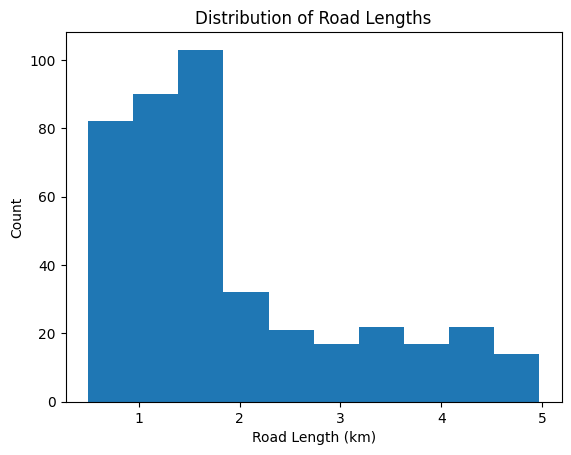

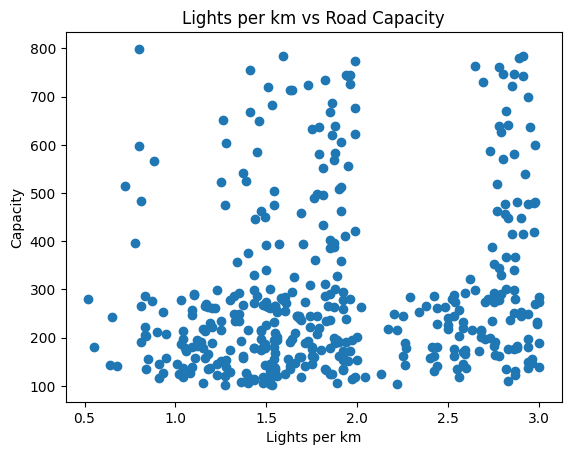

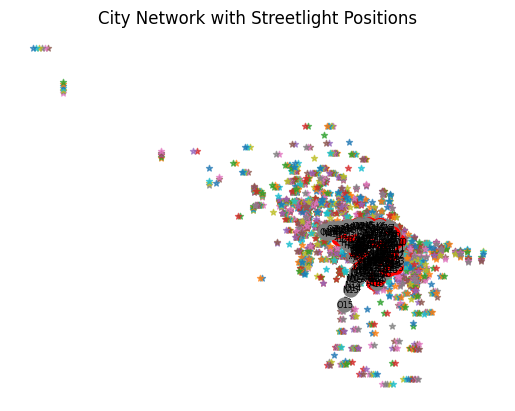

In [5]:
## Additional Visualization Modules for city_lighting_analysis.ipynb
# These functions can be added as new cells in your notebook to showcase your analysis visually

import json
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# 1. Road statistics visualizations

def plot_road_length_distribution(road_stats_path):
    """Histogram of road lengths"""
    with open(road_stats_path) as f:
        data = json.load(f)["road_stats"]
    lengths = [v["length_km"] for v in data.values()]
    plt.figure()
    plt.hist(lengths, bins=10)
    plt.xlabel("Road Length (km)")
    plt.ylabel("Count")
    plt.title("Distribution of Road Lengths")
    plt.show()


def plot_lights_vs_capacity(road_stats_path):
    """Scatter plot: lights_per_km vs capacity"""
    with open(road_stats_path) as f:
        data = json.load(f)["road_stats"]
    lights = [v["lights_per_km"] for v in data.values()]
    capacity = [v["capacity"] for v in data.values()]
    plt.figure()
    plt.scatter(lights, capacity)
    plt.xlabel("Lights per km")
    plt.ylabel("Capacity")
    plt.title("Lights per km vs Road Capacity")
    plt.show()

# 2. City network layout with streetlights overlay

def draw_city_network(grid_path, streetlights_path):
    """Draws the directed city graph and overlays streetlight positions"""
    # Load graph
    with open(grid_path) as f:
        grid = json.load(f)
    G = nx.DiGraph()
    for node in grid["nodes"]:
        G.add_node(node["id"], zone=node["zone"], traffic_light=node["traffic_light"])
    for link in grid["links"]:
        G.add_edge(link["source"], link["target"], length=link["distance"], capacity=link["capacity"])

    # Layout: use spring layout or custom grid
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes, color by traffic_light
    colors = ["red" if d["traffic_light"] else "gray" for _, d in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=100)
    nx.draw_networkx_edges(G, pos, arrowsize=10)
    nx.draw_networkx_labels(G, pos, font_size=6)

    # Overlay streetlights
    with open(streetlights_path) as f:
        lights = json.load(f)
    for light in lights:
        frm, to = light["from"], light["to"]
        x, y = pos[frm] + (pos[to] - pos[frm]) * light["x"], pos[frm] + (pos[to] - pos[frm]) * light["y"]
        plt.scatter(x, y, marker="*", s=20, alpha=0.7)

    plt.title("City Network with Streetlight Positions")
    plt.axis("off")
    plt.show()

# 3. Time series of pedestrian and vehicle logs

def plot_traffic_timeseries(ped_log_csv, veh_log_csv):
    """Overlay time-series plots of pedestrian and vehicle counts"""
    ped = pd.read_csv(ped_log_csv, parse_dates=["timestamp"] )
    veh = pd.read_csv(veh_log_csv, parse_dates=["timestamp"] )

    ped_count = ped.groupby("timestamp")["count"].sum().rename("Pedestrians")
    veh_count = veh.groupby("timestamp")["count"].sum().rename("Vehicles")
    df = pd.concat([ped_count, veh_count], axis=1).fillna(0)

    plt.figure()
    df.plot()
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.title("Pedestrian vs Vehicle Traffic Over Time")
    plt.show()

# 4. Heatmap of average lights_per_km by road type

def plot_heatmap_lights_by_type(road_stats_path):
    """Heatmap: average lights_per_km across road types"""
    with open(road_stats_path) as f:
        data = json.load(f)["road_stats"]
    df = pd.DataFrame(data).T
    pivot = df.pivot_table(index="road_type", values="lights_per_km", aggfunc="mean")

    plt.figure()
    plt.imshow(pivot, aspect="auto")
    plt.xticks([], [])
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.colorbar(label="Avg Lights/km")
    plt.title("Average Lights per km by Road Type")
    plt.show()

# Usage: call these functions in separate cells with your file paths:
plot_road_length_distribution("city_analysis.json")
plot_lights_vs_capacity("city_analysis.json")
draw_city_network("city_grid.json", "streetlights.json")
#plot_traffic_timeseries("pedestrians_log_1.csv", "vehicles_log_1.csv")
#plot_heatmap_lights_by_type("city_analysis.json")
